# Primary Stock Forecast Algorithm

### Tensorflow Version Check

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

2.2.0-rc3


### Imports

In [2]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-poster')

### Reading the Data

In [3]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('ITC.csv')

In [5]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN


In [7]:
print(df.columns)

Index(['Unnamed: 0', 'Date ', 'series ', 'OPEN ', 'HIGH ', 'LOW ',
       'PREV. CLOSE ', 'ltp ', 'close ', 'vwap ', '52W H ', '52W L ',
       'VOLUME ', 'VALUE ', 'No of trades '],
      dtype='object')


In [8]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close '].values.reshape(-1, 1)

In [9]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 2000
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (970, 2000, 1) Y.shape (970,)


In [11]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
16/16 [==============================] - 10s 634ms/step - loss: 0.2143 - val_loss: 0.0789
Epoch 2/80
16/16 [==============================] - 10s 598ms/step - loss: 0.0692 - val_loss: 0.0261
Epoch 3/80
16/16 [==============================] - 10s 601ms/step - loss: 0.0327 - val_loss: 0.0081
Epoch 4/80
16/16 [==============================] - 11s 677ms/step - loss: 0.0287 - val_loss: 0.0125
Epoch 5/80
16/16 [==============================] - 11s 672ms/step - loss: 0.0284 - val_loss: 0.0142
Epoch 6/80
16/16 [==============================] - 11s 701ms/step - loss: 0.0291 - val_loss: 0.0087
Epoch 7/80
16/16 [==============================] - 11s 703ms/step - loss: 0.0298 - val_loss: 0.0113
Epoch 8/80
16/16 [==============================] - 11s 672ms/step - loss: 0.0277 - val_loss: 0.0132
Epoch 9/80
16/16 [==============================] - 11s 667ms/step - loss: 0.0286 - val_loss: 0.0071
Epoch 10/80
16/16 [==============================] - 11s 668ms/step - loss: 0.0274 - val_lo

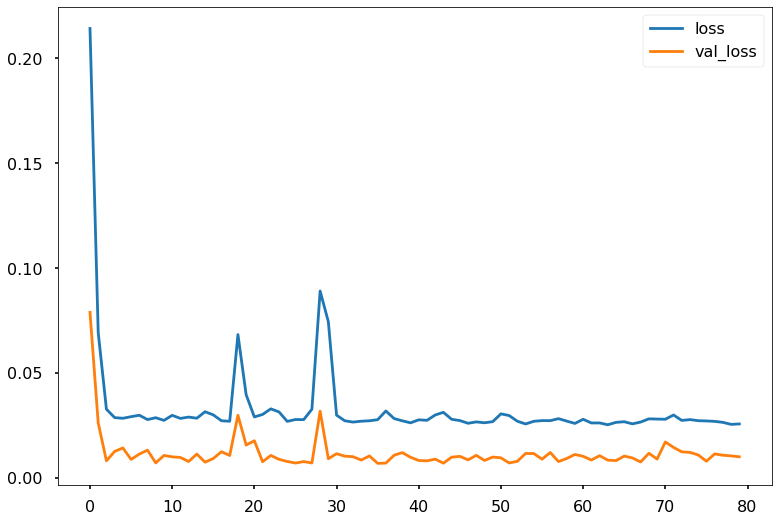

In [12]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [37]:
print((r.history['loss']))

[0.9908673763275146, 0.9894931316375732, 0.987737238407135, 0.9902890920639038, 0.9871252179145813, 0.9849150776863098, 0.9977865815162659, 0.9868704676628113, 0.9958065152168274, 0.9871565103530884, 0.9867010116577148, 0.986548900604248, 0.9901836514472961, 0.9914527535438538, 0.9871289730072021, 0.9914016723632812, 0.986219048500061, 0.9891985654830933, 0.9827446341514587, 0.9828122854232788, 0.9853342175483704, 0.9827172160148621, 0.9831361174583435, 0.9822969436645508, 0.9893291592597961, 0.9818969368934631, 0.982752799987793, 0.975195050239563, 0.9925596117973328, 0.9765748381614685, 0.9931483864784241, 0.9763253331184387, 0.975163459777832, 0.9692296981811523, 0.9639809727668762, 0.9659977555274963, 0.9779850840568542, 0.9688548445701599, 0.9726216793060303, 0.9582651853561401, 0.9583491683006287, 0.9623274207115173, 0.9746764302253723, 0.9478984475135803, 0.951368510723114, 0.9784218072891235, 0.9607914090156555, 0.95042884349823, 0.947713315486908, 0.974495530128479, 0.93329465

In [39]:
fig = px.line(y=r.history['val_loss'])
fig.show()

In [48]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, 'ro', label='predictions')
plt.legend()
plt.show()

ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1150 predict_function  *
        outputs = self.distribute_strategy.run(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1125 predict_step  **
        return self(x, training=False)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:224 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer lstm_2: expected shape=(None, None, 5), found shape=[None, 10, 1]


In [45]:
px.scatter(y=predictions)

In [50]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1150 predict_function  *
        outputs = self.distribute_strategy.run(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1125 predict_step  **
        return self(x, training=False)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:224 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer lstm_2: expected shape=(None, None, 5), found shape=[None, 10, 1]


In [51]:

fig = px.line(validation_target)
fig.show()

In [15]:
# calculate returns by first shifting the data
df['PREV. CLOSE'] = df['close '].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [16]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN,NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN,269.25
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN,267.75
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN,269.45
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN,266.25


In [17]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close '] - df['PREV. CLOSE']) / df['PREV. CLOSE']

In [18]:
df.head()

,Unnamed: 0,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades,PREV. CLOSE,Return
0,0,09-Apr-2010,EQ,267.80,270.50,265.70,267.75,268.50,269.25,268.64,272.9,177.5,2800852,"752,423,958.40",NaN,NaN,NaN
1,1,08-Apr-2010,EQ,268.00,268.95,266.35,269.45,266.70,267.75,267.77,272.9,177.5,2086042,"558,576,804.60",NaN,269.25,-0.005571
2,2,07-Apr-2010,EQ,265.35,270.00,263.50,266.25,269.45,269.45,266.22,272.9,177.5,2910180,"774,754,436.65",NaN,267.75,0.006349
3,3,06-Apr-2010,EQ,264.80,267.60,263.10,264.80,266.25,266.25,264.99,272.9,177.5,3224970,"854,593,065.00",NaN,269.45,-0.011876
4,4,05-Apr-2010,EQ,267.70,268.70,264.10,264.00,264.40,264.80,265.43,272.9,177.5,2445140,"649,016,104.60",NaN,266.25,-0.005446


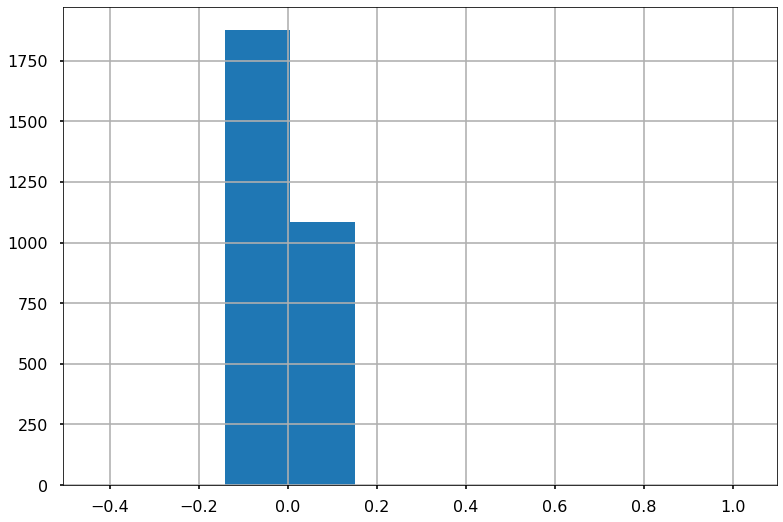

In [19]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [53]:
px.histogram(x=df['Return'])

In [20]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [21]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2959, 10, 1) Y.shape (2959,)


In [22]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
47/47 [==============================] - 1s 16ms/step - loss: 0.9909 - val_loss: 0.6549
Epoch 2/80
47/47 [==============================] - 0s 7ms/step - loss: 0.9895 - val_loss: 0.6505
Epoch 3/80
47/47 [==============================] - 0s 9ms/step - loss: 0.9877 - val_loss: 0.6508
Epoch 4/80
47/47 [==============================] - 1s 11ms/step - loss: 0.9903 - val_loss: 0.6512
Epoch 5/80
47/47 [==============================] - 0s 10ms/step - loss: 0.9871 - val_loss: 0.6513
Epoch 6/80
47/47 [==============================] - 0s 8ms/step - loss: 0.9849 - val_loss: 0.6507
Epoch 7/80
47/47 [==============================] - 0s 7ms/step - loss: 0.9978 - val_loss: 0.6513
Epoch 8/80
47/47 [==============================] - 0s 8ms/step - loss: 0.9869 - val_loss: 0.6515
Epoch 9/80
47/47 [==============================] - 0s 7ms/step - loss: 0.9958 - val_loss: 0.6519
Epoch 10/80
47/47 [==============================] - 0s 7ms/step - loss: 0.9872 - val_loss: 0.6533
Epoch 11/80
47/4

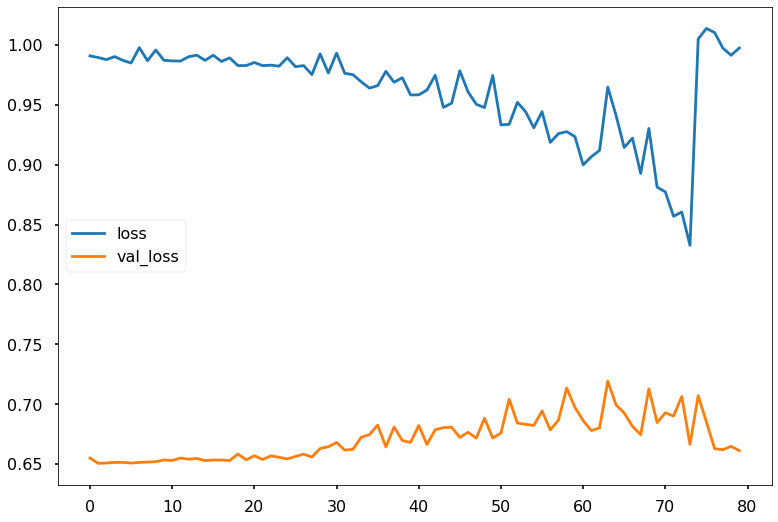

In [23]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(2959, 1)


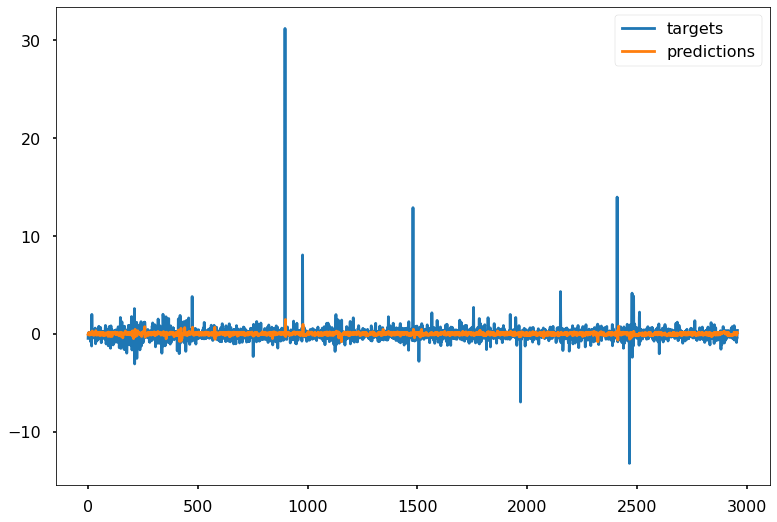

In [24]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

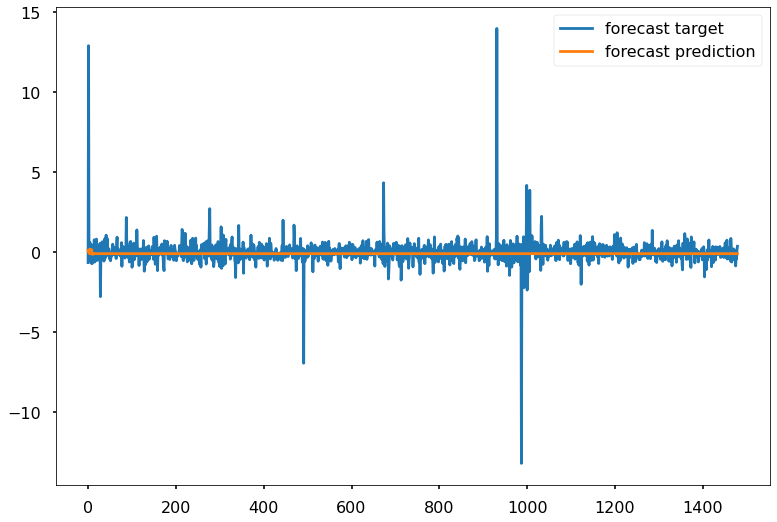

In [25]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [26]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['OPEN ', 'HIGH ', 'LOW ', 'close ', 'VOLUME ']].values
targets = df['Return'].values

In [27]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [28]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [29]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [30]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [31]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [32]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=1000, ##CHANGE BACK TO 300 OR LESS
  validation_data=(X_test, Y_test),
)

Epoch 1/1000
62/62 [==============================] - 1s 12ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6908 - val_accuracy: 0.5194
Epoch 2/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5177 - val_loss: 0.6911 - val_accuracy: 0.5163
Epoch 3/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5298 - val_loss: 0.6923 - val_accuracy: 0.5071
Epoch 4/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5394 - val_loss: 0.6911 - val_accuracy: 0.5163
Epoch 5/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5399 - val_loss: 0.6914 - val_accuracy: 0.5194
Epoch 6/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.5409 - val_loss: 0.6903 - val_accuracy: 0.5082
Epoch 7/1000
62/62 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.5419 - val_loss: 0.6914 - val_accuracy: 0.5194
Epoch

62/62 [==============================] - 0s 7ms/step - loss: 0.4087 - accuracy: 0.8419 - val_loss: 0.7044 - val_accuracy: 0.6480
Epoch 59/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.4084 - accuracy: 0.8465 - val_loss: 0.7814 - val_accuracy: 0.6194
Epoch 60/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.3999 - accuracy: 0.8490 - val_loss: 0.7680 - val_accuracy: 0.6337
Epoch 61/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.3990 - accuracy: 0.8399 - val_loss: 0.7597 - val_accuracy: 0.6337
Epoch 62/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.3953 - accuracy: 0.8490 - val_loss: 0.7825 - val_accuracy: 0.6398
Epoch 63/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.3881 - accuracy: 0.8520 - val_loss: 0.7846 - val_accuracy: 0.6367
Epoch 64/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.3836 - accuracy: 0.8470 - val_loss: 0.8585 - val_accuracy: 0.6122
Epoch 65/1000

62/62 [==============================] - 1s 8ms/step - loss: 0.2015 - accuracy: 0.9343 - val_loss: 1.3898 - val_accuracy: 0.6041
Epoch 116/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.2036 - accuracy: 0.9354 - val_loss: 1.4361 - val_accuracy: 0.6010
Epoch 117/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.2005 - accuracy: 0.9313 - val_loss: 1.4241 - val_accuracy: 0.5980
Epoch 118/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.1952 - accuracy: 0.9399 - val_loss: 1.4731 - val_accuracy: 0.6000
Epoch 119/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.1864 - accuracy: 0.9439 - val_loss: 1.4772 - val_accuracy: 0.5990
Epoch 120/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.1870 - accuracy: 0.9394 - val_loss: 1.4705 - val_accuracy: 0.6031
Epoch 121/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.1801 - accuracy: 0.9414 - val_loss: 1.5180 - val_accuracy: 0.6000
Epoch 1

Epoch 172/1000
62/62 [==============================] - 1s 9ms/step - loss: 0.0601 - accuracy: 0.9899 - val_loss: 2.0523 - val_accuracy: 0.5990
Epoch 173/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0584 - accuracy: 0.9914 - val_loss: 2.0311 - val_accuracy: 0.6000
Epoch 174/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0594 - accuracy: 0.9884 - val_loss: 2.0392 - val_accuracy: 0.5959
Epoch 175/1000
62/62 [==============================] - 1s 9ms/step - loss: 0.0520 - accuracy: 0.9919 - val_loss: 2.0293 - val_accuracy: 0.5949
Epoch 176/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.9939 - val_loss: 2.0850 - val_accuracy: 0.5959
Epoch 177/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.0659 - accuracy: 0.9838 - val_loss: 2.1529 - val_accuracy: 0.5949
Epoch 178/1000
62/62 [==============================] - 1s 9ms/step - loss: 0.0614 - accuracy: 0.9838 - val_loss: 2.1225 - val_accuracy:

Epoch 229/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9990 - val_loss: 2.2989 - val_accuracy: 0.6000
Epoch 230/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0227 - accuracy: 0.9990 - val_loss: 2.3433 - val_accuracy: 0.5949
Epoch 231/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9995 - val_loss: 2.3548 - val_accuracy: 0.5969
Epoch 232/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9995 - val_loss: 2.3688 - val_accuracy: 0.5949
Epoch 233/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9995 - val_loss: 2.3801 - val_accuracy: 0.5898
Epoch 234/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9995 - val_loss: 2.3929 - val_accuracy: 0.5929
Epoch 235/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0175 - accuracy: 0.9995 - val_loss: 2.4120 - val_accuracy:

Epoch 286/1000
62/62 [==============================] - 1s 13ms/step - loss: 0.0106 - accuracy: 0.9995 - val_loss: 2.6922 - val_accuracy: 0.5888
Epoch 287/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.0105 - accuracy: 0.9995 - val_loss: 2.6853 - val_accuracy: 0.5878
Epoch 288/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 0.9995 - val_loss: 2.6943 - val_accuracy: 0.5867
Epoch 289/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 2.7070 - val_accuracy: 0.5878
Epoch 290/1000
62/62 [==============================] - 1s 9ms/step - loss: 0.0101 - accuracy: 0.9995 - val_loss: 2.7004 - val_accuracy: 0.5878
Epoch 291/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0097 - accuracy: 0.9995 - val_loss: 2.7010 - val_accuracy: 0.5857
Epoch 292/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.0098 - accuracy: 0.9995 - val_loss: 2.7103 - val_accuracy

Epoch 343/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0091 - accuracy: 0.9995 - val_loss: 2.4828 - val_accuracy: 0.5908
Epoch 344/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0085 - accuracy: 0.9995 - val_loss: 2.4858 - val_accuracy: 0.5898
Epoch 345/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0080 - accuracy: 0.9995 - val_loss: 2.4952 - val_accuracy: 0.5878
Epoch 346/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.9995 - val_loss: 2.4983 - val_accuracy: 0.5888
Epoch 347/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 2.5092 - val_accuracy: 0.5888
Epoch 348/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0072 - accuracy: 0.9995 - val_loss: 2.5150 - val_accuracy: 0.5857
Epoch 349/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 2.5214 - val_accuracy:

Epoch 400/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0646 - accuracy: 0.9828 - val_loss: 2.3660 - val_accuracy: 0.5878
Epoch 401/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0387 - accuracy: 0.9894 - val_loss: 2.3681 - val_accuracy: 0.5857
Epoch 402/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 2.3957 - val_accuracy: 0.5898
Epoch 403/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9970 - val_loss: 2.4095 - val_accuracy: 0.5867
Epoch 404/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 2.4120 - val_accuracy: 0.5857
Epoch 405/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 2.4736 - val_accuracy: 0.5857
Epoch 406/1000
62/62 [==============================] - 1s 8ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 2.4889 - val_accuracy:

Epoch 457/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.7494 - val_accuracy: 0.5898
Epoch 458/1000
62/62 [==============================] - 0s 7ms/step - loss: 9.9131e-04 - accuracy: 1.0000 - val_loss: 2.7628 - val_accuracy: 0.5888
Epoch 459/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.7616 - val_accuracy: 0.5908
Epoch 460/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.7710 - val_accuracy: 0.5898
Epoch 461/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.7832 - val_accuracy: 0.5898
Epoch 462/1000
62/62 [==============================] - 0s 7ms/step - loss: 9.2196e-04 - accuracy: 1.0000 - val_loss: 2.7867 - val_accuracy: 0.5898
Epoch 463/1000
62/62 [==============================] - 0s 7ms/step - loss: 8.5607e-04 - accuracy: 1.0000 - val_loss: 2.7891 - v

62/62 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.6172 - val_accuracy: 0.5796
Epoch 514/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.6182 - val_accuracy: 0.5786
Epoch 515/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.6210 - val_accuracy: 0.5776
Epoch 516/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.6237 - val_accuracy: 0.5765
Epoch 517/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.6229 - val_accuracy: 0.5755
Epoch 518/1000
62/62 [==============================] - 0s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.6258 - val_accuracy: 0.5765
Epoch 519/1000
62/62 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.6260 - val_accuracy: 0.5765
Epoch 5

KeyboardInterrupt: 

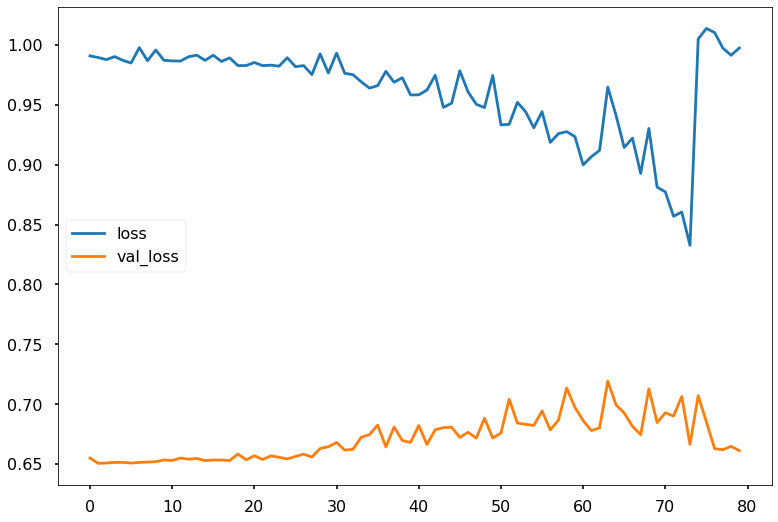

In [54]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [55]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

KeyError: 'accuracy'